## CUSTOMER COMPLAINT CLASSIFICATION USING BERT 

##### The insperation to the project 
[Research gate conference paper](https://www.researchgate.net/publication/360932359_BERT-Based_GitHub_Issue_Report_Classification)

#### DataSource:
[consumer-complaint-database](https://catalog.data.gov/dataset/consumer-complaint-database)

GloVe embeddings:[GloVe](https://github.com/stanfordnlp/GloVe)
glove.6B.50d.txt file is used in this project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ktrain
from ktrain import text
import tensorflow as tf
from sklearn.model_selection import train_test_split
from datasets import list_datasets
from datasets import load_dataset
import timeit
from sklearn import model_selection, preprocessing
import re

In [5]:
data_path = "Input/complaints.csv"

In [6]:
raw_df = pd.read_csv(data_path)
raw_df.head(1)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605


In [7]:
raw_df.shape

(2326246, 18)

In [8]:
### Check for the null values in the dataset
null_per = pd.DataFrame((raw_df.isnull().sum()/raw_df.shape[0]*100))
null_per.columns = ["null_per"]

null_per.sort_values(by='null_per', ascending=False, inplace=True)
null_per['null_per'] = null_per['null_per'].apply(lambda x: round(x))
null_per

,null_per
Tags,88
Consumer disputed?,67
Consumer complaint narrative,65
Company public response,59
Consumer consent provided?,31
Sub-issue,27
Sub-product,10
ZIP code,10
State,2
Company response to consumer,0


In [9]:
### The column names to lower case
raw_df.columns = [str(x).lower() for x in raw_df]
raw_df.columns

Index(['date received', 'product', 'sub-product', 'issue', 'sub-issue',
       'consumer complaint narrative', 'company public response', 'company',
       'state', 'zip code', 'tags', 'consumer consent provided?',
       'submitted via', 'date sent to company', 'company response to consumer',
       'timely response?', 'consumer disputed?', 'complaint id'],
      dtype='object')

In [10]:
### Target columns: The column "consumer complaint narrative" is the input text column and "product" is the target column
req_df = raw_df[["consumer complaint narrative","product"]]

In [11]:
# Dropping all the rows where the "consumer complaint narrative" values are null as there is no explanationtion of complaint we can't classify it.
text_col_name = "consumer complaint narrative"
df_prep = req_df[pd.notnull(req_df['consumer complaint narrative'])]
df_prep.dropna(subset=[text_col_name], inplace=True)
df_prep.shape

C:\Users\gayathri.pamuluru\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(809343, 2)

In [12]:
### Checking the dependent column
label_col = 'product'
df_prep[label_col].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    316465
Debt collection                                                                 157381
Mortgage                                                                         84461
Credit card or prepaid card                                                      60754
Checking or savings account                                                      37389
Credit reporting                                                                 31588
Student loan                                                                     29094
Credit card                                                                      18838
Money transfer, virtual currency, or money service                               18583
Vehicle loan or lease                                                            15034
Bank account or service                                                          14885
Payday loan, title loan, or personal loan  

In [13]:
### Label mapping for better classification
label_map = {'Vehicle loan or lease': 'vehicle_loan',
               'Credit reporting, credit repair services, or other personal consumer reports': 'credit_report',
               'Credit card or prepaid card': 'card',
               'Money transfer, virtual currency, or money service': 'money_transfer',
               'virtual currency': 'money_transfer',
               'Mortgage': 'mortgage',
               'Payday loan, title loan, or personal loan': 'loan',
               'Debt collection': 'debt_collection',
               'Checking or savings account': 'savings_account',
               'Credit card': 'card',
               'Bank account or service': 'savings_account',
               'Credit reporting': 'credit_report',
               'Prepaid card': 'card',
               'Payday loan': 'loan',
               'Other financial service': 'others',
               'Virtual currency': 'money_transfer',
               'Student loan': 'loan',
               'Consumer Loan': 'loan',
               'Money transfers': 'money_transfer'}
df_prep.replace({label_col: label_map}, inplace=True)

C:\Users\gayathri.pamuluru\Anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


<AxesSubplot:xlabel='product', ylabel='count'>

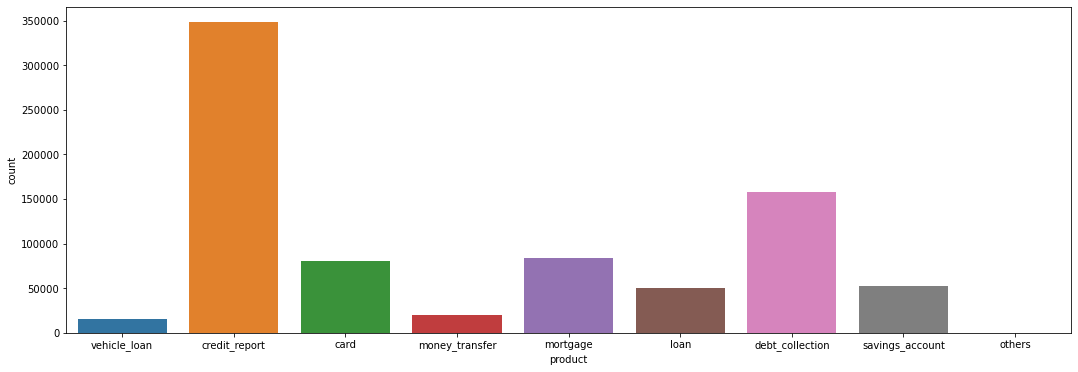

In [14]:
fig,ax = plt.subplots(figsize=(18,6))
sns.countplot(x='product',data=df_prep)

In [15]:
### text format to lower case
df_prep['consumer complaint narrative'] =df_prep['consumer complaint narrative'].apply(lambda x: ' '.join([i.lower() for i in str(x).split()]))
df_prep['consumer complaint narrative'].head()

C:\Users\gayathri.pamuluru\Anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


1     i contacted ally on friday xx/xx/xxxx after fa...
7     hello this complaint is against the three cred...
8     i am a victim of identity theft & currently ha...
10    two accounts are still on my credit history af...
13    receiving daily telephone call ( s ) from xxxx...
Name: consumer complaint narrative, dtype: object

In [16]:
# Remove stopwords because those words don't describe the topic like the words "of",'an','the','it'etc
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
df_prep['consumer complaint narrative'] =df_prep['consumer complaint narrative'].apply(lambda x: ' '.join([i for i in x.split() if i not in stop]))
df_prep['consumer complaint narrative'].head()

1     contacted ally friday xx/xx/xxxx falling behin...
7     hello complaint three credit reporting compani...
8     victim identity theft & currently experian acc...
10    two accounts still credit history contacting c...
13    receiving daily telephone call ( ) xxxx xxxx x...
Name: consumer complaint narrative, dtype: object

In [17]:
### remove more stopwords
stop_words = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]
df_prep['consumer complaint narrative'] = df_prep['consumer complaint narrative'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stop_words)]))
df_prep['consumer complaint narrative'].head()

1     contacted ally friday xx/xx/xxxx falling behin...
7     hello complaint three credit reporting compani...
8     victim identity theft & currently experian acc...
10    two accounts still credit history contacting c...
13    receiving daily telephone call ( ) xxxx xxxx x...
Name: consumer complaint narrative, dtype: object

In [20]:
### removing the digits
df_prep['consumer complaint narrative'] =df_prep['consumer complaint narrative'].apply(lambda x: re.sub("\d+", "", x))
df_prep['consumer complaint narrative'].head()

1     contacted ally friday xx/xx/xxxx falling behin...
7     hello complaint three credit reporting compani...
8     victim identity theft & currently experian acc...
10    two accounts still credit history contacting c...
13    receiving daily telephone call ( ) xxxx xxxx x...
Name: consumer complaint narrative, dtype: object

In [21]:
### Removing punctuations except apostrophe
df_prep['consumer complaint narrative'] =df_prep['consumer complaint narrative'].apply(lambda x: re.sub(r"[^\w\d'\s]+", "", x))
df_prep['consumer complaint narrative'].head()

1     contacted ally friday xxxxxxxx falling behind ...
7     hello complaint three credit reporting compani...
8     victim identity theft  currently experian acco...
10    two accounts still credit history contacting c...
13    receiving daily telephone call   xxxx xxxx xxx...
Name: consumer complaint narrative, dtype: object

In [22]:
### Remvoing the repetetive strings such as "xxxxxxxx"
df_prep['consumer complaint narrative'] =df_prep['consumer complaint narrative'].apply(lambda x: re.sub(r'[x]{2,}', "", x))
df_prep['consumer complaint narrative'].head()

1     contacted ally friday  falling behind payments...
7     hello complaint three credit reporting compani...
8     victim identity theft  currently experian acco...
10    two accounts still credit history contacting c...
13    receiving daily telephone call      identifyin...
Name: consumer complaint narrative, dtype: object

In [23]:
### Replacing the more than single space with just single space
df_prep['consumer complaint narrative'] =df_prep['consumer complaint narrative'].apply(lambda x: re.sub(' +', " ", x))
df_prep['consumer complaint narrative'].head()

1     contacted ally friday falling behind payments ...
7     hello complaint three credit reporting compani...
8     victim identity theft currently experian accou...
10    two accounts still credit history contacting c...
13    receiving daily telephone call identifying att...
Name: consumer complaint narrative, dtype: object

In [24]:
df_prep1 = df_prep.copy()
df_input = df_prep.copy()

In [25]:
df_input.columns = ["consumer_complaint_narrative","product"]


In [27]:
class_label_names = df_input['product'].unique().tolist()
class_label_names

['vehicle_loan',
 'credit_report',
 'card',
 'money_transfer',
 'mortgage',
 'loan',
 'debt_collection',
 'savings_account',
 'others']

In [28]:
### The classification labels to dict
class_label_dict={class_label_names[ind]:ind for ind in range(0,len(class_label_names))}
class_label_dict

{'vehicle_loan': 0,
 'credit_report': 1,
 'card': 2,
 'money_transfer': 3,
 'mortgage': 4,
 'loan': 5,
 'debt_collection': 6,
 'savings_account': 7,
 'others': 8}

In [29]:
### encoding the column labels(replacing the labels with numbers)
df_input_label = df_input.copy()
df_input_label.replace({"product": class_label_dict}, inplace=True)
df_input_label.head(2)

,consumer_complaint_narrative,product
1,contacted ally friday falling behind payments ...,0
7,hello complaint three credit reporting compani...,1


In [90]:
df = df_input_label.copy()
df.head(2)


,consumer_complaint_narrative,product
1,contacted ally friday falling behind payments ...,0
7,hello complaint three credit reporting compani...,1


In [91]:
df.dropna(inplace=True)
df.head(2)


,consumer_complaint_narrative,product
1,contacted ally friday falling behind payments ...,0
7,hello complaint three credit reporting compani...,1


In [88]:
# df.to_csv("Cleaned_consumer_complaint_narrative.csv", index="Flase")

In [92]:
### Shape of the data after preprocessing
df.shape

(809343, 2)

In [104]:
df["product"].value_counts()

1    348053
6    157381
4     84461
2     81042
7     52274
5     50710
3     20096
0     15034
8       292
Name: product, dtype: int64

In [31]:
#We will contain our tensors within two numpy arrays, which will be of dimensions len(df) * 512 - the 512 is the sequence length of our tokenized sequences for BERT, and len(df) the number of samples in our dataset.
seq_len = 512
num_samples = len(df)
num_samples, seq_len

(809343, 512)

In [93]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer

### Tokenization

In [94]:
### loading the pretrained bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [96]:
### encoding the tokens
token = tokenizer.encode_plus(
    df['consumer_complaint_narrative'].iloc[0], 
    max_length=256,  # default in Bert is 512
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)

In [97]:
token.input_ids

<tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[  101, 12017, 11989,   175, 22977,  1183,  4058,  1481, 10772,
         1496,  1250,  1603,  1669,  1159,  1496,  6946, 13287,  1174,
         4702, 17844,  3300,  4423, 11769,  8934,  1116,  4989,  3244,
         4755,  2498,  3300,  1954,  9213,  4252, 23826,  2116,  1694,
         1294,  7727,  2971,  7815, 18488,  1773,  3963, 10020,  1189,
         7727, 19863,  6194,  1231,  1643,  9213,  1143,  7727,  8345,
         3300,  3232, 11989,  1171,  6102,  1988,  7727, 19353,  6732,
         1174,  1322,  4891,  1713, 12017, 11989,  2052, 13287,  1906,
         3716,  1869,  2136, 13287,  1906,  1231,  1643,  1314,  1989,
         1455,  1317,  3243,  9213,  1141,  1160,  2370,  4973,  2007,
        12929,  1174,  7727,  1694,  1649,  7597,  7727,  1834,  1184,
         9213,  1164,  1116,  1496,  1439,  1552, 10795,  3311,  2735,
          171,  1348,  1164,  1116,  1496, 10772,  1679,  2370, 14926,
         1692,  2356,  1189, 

### Data Preparation for Bert model

In [98]:
### creating the zero matrics to prepare the tokeniged data to pass it to bert model
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

In [99]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['consumer_complaint_narrative'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [100]:
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [105]:
### creating array for classification labels. The "product" column have 9 classes. 
labels = np.zeros((len(df), 9))
labels.shape

(809343, 9)

In [106]:
labels[np.arange(len(df)), df['product'].values] = 1 # one-hot encoded target tensor

In [107]:
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [108]:
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(9,), dtype=tf.float64, name=None))>

In [109]:
def ClassificationDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [110]:
dataset = dataset.map(ClassificationDatasetMapFunction) # converting to required format for tensorflow dataset

In [111]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(9,), dtype=tf.float64, name=None))>

### Train Test Split

In [112]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [113]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 9), dtype=tf.float64, name=None))>

In [114]:
p = 0.8
train_size = int((len(df)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

In [115]:
train_size

40466

In [116]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

### MODEL

Building the model using tensorflow BERT(Bidirectional encoder representation from transformers)

In [117]:
from transformers import TFBertModel

In [118]:
model = TFBertModel.from_pretrained('bert-base-cased') # bert base model with pretrained weights

In [120]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(9, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

multi_class_bert_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
multi_class_bert_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPooling(last_hidd               'attention_mask[0][0]']         
                                en_state=(None, 256                                               
                                , 768),                                                     

### Model Optimization

In [121]:
### Using the Adam optimizer, Categorical Cross entropy as loss function and the accuracy as performance metric
optim = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [122]:
### Compling the model
multi_class_bert_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

### Model Training

In [123]:
### Training the model 
hist = multi_class_bert_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2
)

Epoch 1/2
 2474/40466 [>.............................] - ETA: 251:13:40 - loss: 0.7151 - accuracy: 0.7582

KeyboardInterrupt: 

The Bert model trained for 24 hours with 8GB CPU processor and then knowingly interrupterd the kernal as it is taking too long to get trained. Upto this point the model accuracy is 75%.

In [124]:
### Saving the trained model
multi_class_bert_model.save('multi_class_bert_model_e5')

### ML Pipeline: 

In [125]:
### To make predictions

multi_class_bert_model = tf.keras.models.load_model('multi_class_bert_model_e5')

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

### Can have a function for text preprocessing

### Preparing the data such way that the text can we feched to model
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

### fetching the preproceed and prepared data to predict method
def make_prediction(model, processed_data, classes= class_label_names):
    probs = model.predict(processed_data)[0]
    return classes[np.argmax(probs)]

### Prediction

In [132]:
### Predict for single complaint
input_text = input('Enter consumer complaint here: ')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(multi_class_bert_model, processed_data=processed_data)
print(f"Predicted Product: {result}")

Enter consumer complaint here: calling parents leaving messages put warrant arrest leaving voicemails phone sending someone house 've never received papers people call different number parents phone one left name number asked pay bills without job said grace started insulting religion
1/1 [==============================] - 3s 3s/step
Predicted Product: debt_collection


In [134]:
print(f"Predicted Product: {result}")

Predicted Product: debt_collection


Implemented the RNN model which gave the 69% accuracy(I took 12hrs to get trained with learning rate 0.01) and then trained the Bert model with learning rate 1e-5 may be the reason to take xtoo long for training. 

### Further possible improvements

* Imbalanced data handling: Before training the model, the weights can be added for handling data imblance as few labels have higher samples and few have very less.
* Hyperparameter Tuning:As specified can tweek and check the other parameters like tokenigers "max_length", model 
* Recent Models: Try building the recent models like ALBERT and compare the performance.